In [ ]:
!pip install pad_sequences

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pad-sequences: filename=pad_sequences-0.6.1-py3-none-any.whl size=10216 sha256=0b820a86a0ba0f810f0a73fe113500d6acb8c66609e880ebcfa8772428ca441e
  Stored in directory: /root/.cache/pip/wheels/51/e4/5c/d3610ed4476515e540ff4096e3e9a8a3e701dedfe1072eb000
Successfully built pad-sequences


In [ ]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import operator
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

import re

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Conv1D,LSTM,GRU,BatchNormalization,Flatten,Dense


In [ ]:
train_pos = pd.read_csv('/content/drive/MyDrive/train_pos.csv')
train_neg = pd.read_csv('/content/drive/MyDrive/train_neg.csv')
test_pos = pd.read_csv('/content/drive/MyDrive/test_pos.csv')
test_neg = pd.read_csv('/content/drive/MyDrive/test_neg.csv')
train = [train_pos, train_neg]
train = pd.concat(train)
df = train

In [ ]:
df.head()

,Unnamed: 0,review,rating,sentiment
0,0,Excellent pirate entertainment! It has all the...,10,1
1,1,"I barely remember this show, a little ,but I r...",8,1
2,2,I was bored one night and Red Eye was on and t...,9,1
3,3,Great little thriller. I was expecting some ty...,8,1
4,4,A couple of years back I had purchased (and en...,7,1


In [ ]:
sentences=df['review']
le=LabelEncoder()
df['sentiment']= le.fit_transform(df['sentiment'])

(-0.5, 799.5, 799.5, -0.5)

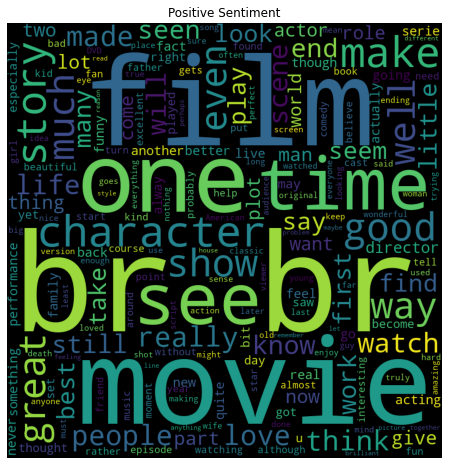

In [ ]:
stopwords = set(STOPWORDS)

pos = ' '.join(map(str,sentences[df['sentiment']==1]))
neg = ' '.join(map(str,sentences[df['sentiment']==0]))

wordcloud1 = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(pos)

plt.figure(figsize=(8,8))
plt.imshow(wordcloud1)
plt.title('Positive Sentiment')
plt.axis('off')

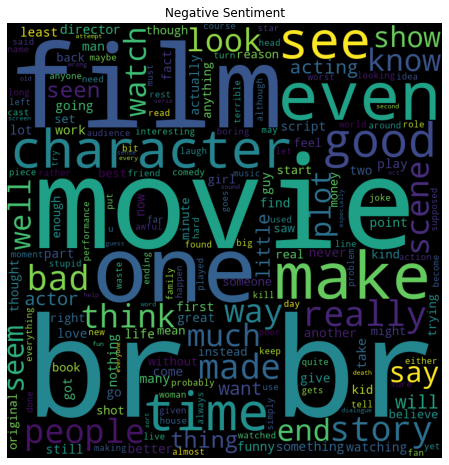

In [ ]:
plt.figure(figsize=(8,8))
wordcloud2 = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(neg)

plt.imshow(wordcloud2)
plt.title('Negative Sentiment')
plt.axis('off')

plt.show()

In [ ]:
labels = to_categorical(df['sentiment'], num_classes=2)
X_train, X_test, Y_train, Y_test = train_test_split(df['review'], labels, test_size = 0.1, random_state = 10)

In [ ]:
glove_embeddings= np.load('/content/drive/MyDrive/DM Project/glove.840B.300d.pkl', allow_pickle=True)

In [ ]:
def vocab_build(review):

    comments = review.apply(lambda s: s.split()).values
    vocab={}

    for comment in comments:
        for word in comment:
            try:
                vocab[word]+=1

            except KeyError:
                vocab[word]=1
    return vocab

In [ ]:
def embedding_coverage(review,embeddings):

    vocab=vocab_build(review)

    covered={}
    word_count={}
    oov={}
    covered_num=0
    oov_num=0

    for word in vocab:
        try:
            covered[word]=embeddings[word]
            covered_num+=vocab[word]
            word_count[word]=vocab[word]
        except:
            oov[word]=vocab[word]
            oov_num+=oov[word]

    vocab_coverage=len(covered)/len(vocab)*100
    text_coverage = covered_num/(covered_num+oov_num)*100

    sorted_oov=sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    sorted_word_count=sorted(word_count.items(), key=operator.itemgetter(1))[::-1]

    return sorted_word_count,sorted_oov,vocab_coverage,text_coverage

In [ ]:
train_covered,train_oov,train_vocab_coverage,train_text_coverage=embedding_coverage(X_train,glove_embeddings)
test_covered,test_oov, test_vocab_coverage, test_text_coverage = embedding_coverage(X_test,glove_embeddings)

print(f"Glove embeddings cover {round(train_vocab_coverage,2)}% of vocabulary and {round(train_text_coverage,2)}% text in training set")
print(f"Glove embeddings cover {round(test_vocab_coverage,2)}% of vocabulary and {round(test_text_coverage,2)}% text in testing set")

Glove embeddings cover 31.14% of vocabulary and 87.64% text in training set
Glove embeddings cover 47.31% of vocabulary and 87.45% text in testing set


In [ ]:
train_oov[:10]

[('/><br', 45641),
 ('/>The', 6517),
 ('film,', 3589),
 ('movie,', 3521),
 ('/>I', 3253),
 ("isn't", 2715),
 ('"The', 2132),
 ('/>This', 1987),
 ("he's", 1970),
 ("wasn't", 1950)]

In [ ]:
def clean_sentences(line):

    line=re.sub('<.*?>','',line) # removing html tags

    #removing contractions
    line=re.sub("isn't",'is not',line)
    line=re.sub("he's",'he is',line)
    line=re.sub("wasn't",'was not',line)
    line=re.sub("there's",'there is',line)
    line=re.sub("couldn't",'could not',line)
    line=re.sub("won't",'will not',line)
    line=re.sub("they're",'they are',line)
    line=re.sub("she's",'she is',line)
    line=re.sub("There's",'there is',line)
    line=re.sub("wouldn't",'would not',line)
    line=re.sub("haven't",'have not',line)
    line=re.sub("That's",'That is',line)
    line=re.sub("you've",'you have',line)
    line=re.sub("He's",'He is',line)
    line=re.sub("what's",'what is',line)
    line=re.sub("weren't",'were not',line)
    line=re.sub("we're",'we are',line)
    line=re.sub("hasn't",'has not',line)
    line=re.sub("you'd",'you would',line)
    line=re.sub("shouldn't",'should not',line)
    line=re.sub("let's",'let us',line)
    line=re.sub("they've",'they have',line)
    line=re.sub("You'll",'You will',line)
    line=re.sub("i'm",'i am',line)
    line=re.sub("we've",'we have',line)
    line=re.sub("it's",'it is',line)
    line=re.sub("don't",'do not',line)
    line=re.sub("that´s",'that is',line)
    line=re.sub("I´m",'I am',line)
    line=re.sub("it’s",'it is',line)
    line=re.sub("she´s",'she is',line)
    line=re.sub("he’s'",'he is',line)
    line=re.sub('I’m','I am',line)
    line=re.sub('I’d','I did',line)
    line=re.sub("he’s'",'he is',line)
    line=re.sub('there’s','there is',line)

    #special characters and emojis
    line=re.sub('\x91The','The',line)
    line=re.sub('\x97','',line)
    line=re.sub('\x84The','The',line)
    line=re.sub('\uf0b7','',line)
    line=re.sub('¡¨','',line)
    line=re.sub('\x95','',line)
    line=re.sub('\x8ei\x9eek','',line)
    line=re.sub('\xad','',line)
    line=re.sub('\x84bubble','bubble',line)

    # remove concated words
    line=re.sub('trivialBoring','trivial Boring',line)
    line=re.sub('Justforkix','Just for kix',line)
    line=re.sub('Nightbeast','Night beast',line)
    line=re.sub('DEATHTRAP','Death Trap',line)
    line=re.sub('CitizenX','Citizen X',line)
    line=re.sub('10Rated','10 Rated',line)
    line=re.sub('_The','_ The',line)
    line=re.sub('1Sound','1 Sound',line)
    line=re.sub('blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah','blah blah',line)
    line=re.sub('ResidentHazard','Resident Hazard',line)
    line=re.sub('iameracing','i am racing',line)
    line=re.sub('BLACKSNAKE','Black Snake',line)
    line=re.sub('DEATHSTALKER','Death Stalker',line)
    line=re.sub('_is_','is',line)
    line=re.sub('10Fans','10 Fans',line)
    line=re.sub('Yellowcoat','Yellow coat',line)
    line=re.sub('Spiderbabe','Spider babe',line)
    line=re.sub('Frightworld','Fright world',line)

    #removing punctuations

    punctuations = '@#!~?+&*[]-%._-:/£();$=><|{}^' + '''"“´”'`'''
    for p in punctuations:
        line = line.replace(p, f' {p} ')

    line=re.sub(',',' , ',line)

    # ... and ..
    line = line.replace('...', ' ... ')

    if '...' not in line:
        line = line.replace('..', ' ... ')

    return line

In [ ]:
X_train=X_train.apply(lambda s: clean_sentences(s))
X_test=X_test.apply(lambda s: clean_sentences(s))

train_covered,train_oov,train_vocab_coverage,train_text_coverage=embedding_coverage(X_train,glove_embeddings)
print(f"Glove embeddings cover {round(train_vocab_coverage,2)}% of vocabulary and {round(train_text_coverage,2)}% text in training set")

test_covered,test_oov,test_vocab_coverage,test_text_coverage=embedding_coverage(X_test,glove_embeddings)
print(f"Glove embeddings cover {round(test_vocab_coverage,2)}% of vocabulary and {round(test_text_coverage,2)}% text in training set")

Glove embeddings cover 90.69% of vocabulary and 99.82% text in training set
Glove embeddings cover 96.86% of vocabulary and 99.82% text in training set


In [ ]:
punctuations = '@#!~?+&*[]-%._-:/£();$=><|{},^' + '''"“´”'`'''
train_word=[]
train_count=[]

i=1
for word,count in train_covered:
    if word not in punctuations:
        train_word.append(word)
        train_count.append(count)
        i+=1
    if(i==15):
        break

In [ ]:
test_word=[]
test_count=[]

i=1
for word,count in test_covered:
    if word not in punctuations:
        test_word.append(word)
        test_count.append(count)
        i+=1
    if(i==15):
        break

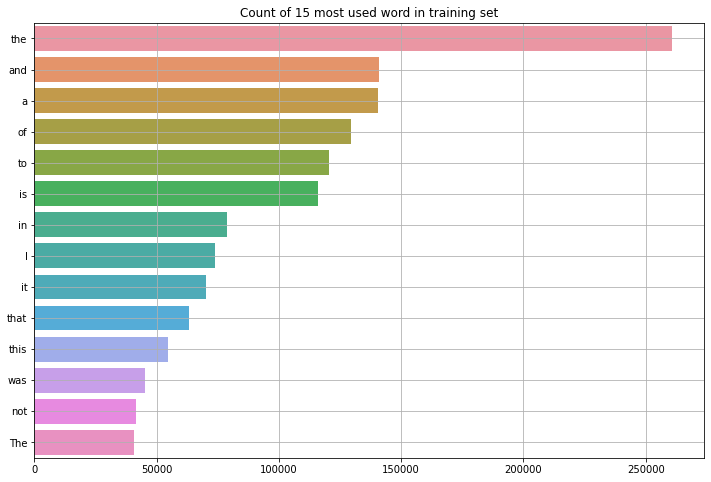

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x=train_count,y=train_word).set_title('Count of 15 most used word in training set')
plt.grid()

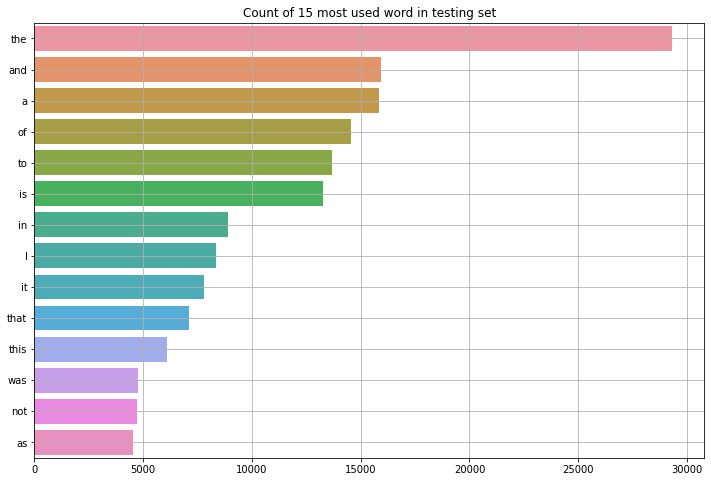

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x=test_count,y=test_word).set_title('Count of 15 most used word in testing set')
plt.grid()

In [ ]:
del glove_embeddings,train_oov,test_oov
gc.collect()

14389

In [ ]:
num_words=80000
embeddings=256
tokenizer=Tokenizer(num_words=num_words,oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index=tokenizer.word_index
total_vocab=len(word_index)
print("Vocabulary of the dataset is : ",total_vocab)

Vocabulary of the dataset is :  73473


In [ ]:
from keras_preprocessing.sequence import pad_sequences
sequences_train=tokenizer.texts_to_sequences(X_train)
sequences_test=tokenizer.texts_to_sequences(X_test)

max_len=max(max([len(x) for x in sequences_train]),max([len(x) for x in sequences_test]))

train_padded=pad_sequences(sequences_train,maxlen=max_len)
test_padded=pad_sequences(sequences_test,maxlen=max_len)

In [ ]:
X_train,X_val,Y_train,Y_val=train_test_split(train_padded,Y_train, test_size=0.05,random_state=10)

In [ ]:
model= keras.Sequential()
model.add(Embedding(num_words,embeddings,input_length=max_len))
model.add(Conv1D(64,10,activation='relu'))
model.add(keras.layers.Bidirectional(LSTM(64,return_sequences=True)))
model.add(LSTM(32))
model.add(keras.layers.Dropout(0.4))
model.add(Dense(2,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2527, 256)         20480000  
                                                                 
 conv1d (Conv1D)             (None, 2518, 64)          163904    
                                                                 
 bidirectional (Bidirectiona  (None, 2518, 128)        66048     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                        

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
             )

In [ ]:
es= EarlyStopping(monitor='val_accuracy',
                  patience=2
                 )

checkpoints=ModelCheckpoint(filepath='./',
                            monitor="val_accuracy",
                            verbose=0,
                            save_best_only=True
                           )

callbacks=[es,checkpoints]

In [ ]:
history=model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=5,callbacks=callbacks)

Epoch 1/5
668/668 [==============================] - ETA: 0s - loss: 0.5099 - accuracy: 0.7469

668/668 [==============================] - 3641s 5s/step - loss: 0.5099 - accuracy: 0.7469 - val_loss: 0.4382 - val_accuracy: 0.7947
Epoch 2/5
668/668 [==============================] - ETA: 0s - loss: 0.2668 - accuracy: 0.8957

668/668 [==============================] - 3687s 6s/step - loss: 0.2668 - accuracy: 0.8957 - val_loss: 0.3546 - val_accuracy: 0.8667
Epoch 3/5
668/668 [==============================] - 3663s 5s/step - loss: 0.1458 - accuracy: 0.9480 - val_loss: 0.3576 - val_accuracy: 0.8658
Epoch 4/5
668/668 [==============================] - ETA: 0s - loss: 0.0946 - accuracy: 0.9693

668/668 [==============================] - 3637s 5s/step - loss: 0.0946 - accuracy: 0.9693 - val_loss: 0.3921 - val_accuracy: 0.8782
Epoch 5/5
668/668 [==============================] - 3641s 5s/step - loss: 0.0512 - accuracy: 0.9843 - val_loss: 0.4807 - val_accuracy: 0.8711
